In [15]:
import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['pdf.fonttype'] = '42'

import time
import hdbscan
import math

# overview

In [2]:
#  use journal names to help interpret the space of papers

# todo also try using titles (they may be braoder scale labels than abstract words)
                          #  ( but finer scale and more plentiful than journal names)

# configure & initialize

In [3]:
## control params

year = 2018   # pmids are listed by year in preprocessed json files
path2dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/year_pmids/'  # knowledge-garden
      #  = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'  # RCC Midway2

In [4]:
# mysql credentials
config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'
db_name = 'test_pubmed'  # db name collison issue? https://stackoverflow.com/questions/14011968/user-cant-access-a-database

with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}

db = pymysql.connect(**client_config)

In [5]:
# dimensionality reduction

########################
## load pre-fit pca models (fit using samples (size=100k) from the full corpus)

#pca_path = '/project2/jevans/brendan/pubmed_data_processing/dimensionality_reduction_models/pca_models/pca_model0.pkl'  # more located at /project2...
#with open(pca_path, 'rb') as file:
#    pca_model = pickle.load(file)
    
#########################

# load the pre-fit umap model  (trained on time-flattened data)

print('pop open pickle jar: umap model...')
umap_path = "/home/brendan/FastData/pubmed2019/pubmed_data_processing/dimensionality_reduction_models/umap2D/umap_model0.pkl"
with open(umap_path, 'rb') as file:
    umap_model = pickle.load(file)

pop open pickle jar: umap model...


# fetch samples

In [6]:
# load list of pmids published in this year

filename = 'pubmed_state_{}'.format(year)
path2pmids = path2dir + filename
with open(path2pmids,'r') as f:
    data = json.load(f)

year_pub_pmids = data['publications']
N_pubs = len(year_pub_pmids)
print("N pubs: {}".format(N_pubs))
del data # clean up


N pubs: 1205220


In [7]:
# generate sample indices

K_sample = 10000
N_samplesets = 2
samples = {}
for i in range(N_samplesets):
    samples[i] = {}
    samples[i]['pmids'] = np.random.choice(year_pub_pmids, K_sample)

In [8]:
# helper function for selecting the embedding vectors

def get_embedding_vectors(sample_pmids):
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])

    sql = '''SELECT E.pmid, E.embedding
            FROM scibert_mean_embedding as E
            WHERE E.pmid IN ({})'''.format(str_fmt)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    pub_embeddings = []
    pub_pmids = []
    for i,row in enumerate(cursor):
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        pub_pmids.append(row[0])
        pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL results fetched and cast in {} s".format(elapsed))
    
    return pub_pmids, pub_embeddings

In [9]:
# populate embedding vectors for these samples

for i in range(N_samplesets):
    pmids, embeddings = get_embedding_vectors(samples[i]['pmids'])
    samples[i]['pmids'] = pmids  # remove pmids with no corresponding embedding (e.g. no abstract)
    samples[i]['raw_coordinates'] = embeddings
    print('compressing...')
    samples[i]['umap2D'] = umap_model.transform(embeddings)
    
# note on the warning-
#   this seems to be a known issue related to tuples in numba no-python mode
#    it's arising due to umap internals + the numba bug

SQL join executed in 0.7758200168609619 s
SQL results fetched and cast in 0.18572497367858887 s
compressing...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/umap/nndescent.py", line 123:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embe

SQL join executed in 0.7137570381164551 s
SQL results fetched and cast in 0.18333005905151367 s
compressing...


Text(0.5, 1.0, 'published: year 2018')

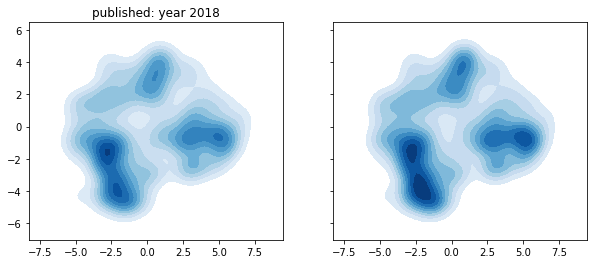

In [10]:
# sanity check - compare umap plots of the two samples

(f, ax) = plt.subplots(1,
                       2,
                       sharex='all', sharey='all',
                       figsize=(10,4))

sns.kdeplot(samples[0]['umap2D'][:,0], # these are pca'd
            samples[0]['umap2D'][:,1],
            ax=ax[0],
            shade=True,
    shade_lowest=False,
            cmap='Blues')
ax[0].set_title('published: year {}'.format(year))

sns.kdeplot(samples[1]['umap2D'][:,0], # these are pca'd
            samples[1]['umap2D'][:,1],
            ax=ax[1],
            shade=True,
    shade_lowest=False,
            cmap='Blues')
ax[0].set_title('published: year {}'.format(year))

In [11]:
# begin experimental exploration of journals
#   # should also build embedding space using the titles

# check top 12 journals for each sample

SQL join executed in 0.15835809707641602 s
SQL results fetched and cast in 0.0031735897064208984 s
number of unique journals in the sample: 
3225
3225
['PLoS ONE', 'Sci Rep', 'Nat Commun', 'Environ Sci Pollut Res Int', 'Sensors (Basel)', 'Sci. Total Environ.', 'Methods Mol. Biol.', 'ACS Appl Mater Interfaces', 'Molecules', 'Int J Mol Sci', 'Medicine (Baltimore)', 'Opt Express']
SQL join executed in 0.16301822662353516 s
SQL results fetched and cast in 0.0032002925872802734 s
number of unique journals in the sample: 
3155
3155
['PLoS ONE', 'Sci Rep', 'Nat Commun', 'Sensors (Basel)', 'Methods Mol. Biol.', 'ACS Appl Mater Interfaces', 'Sci. Total Environ.', 'Environ Sci Pollut Res Int', 'Int J Mol Sci', 'Medicine (Baltimore)', 'Chem. Commun. (Camb.)', 'Zootaxa']


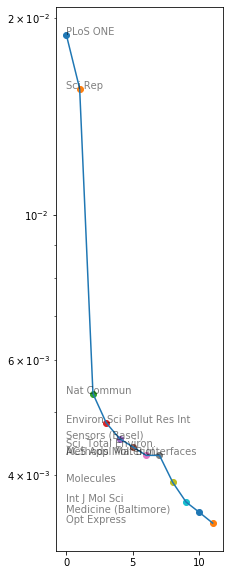

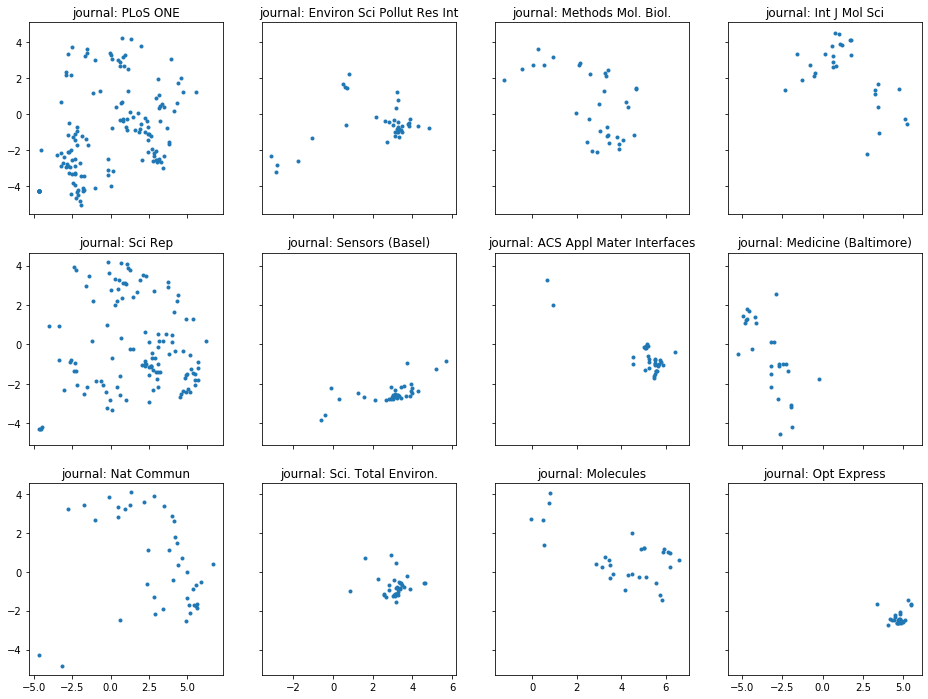

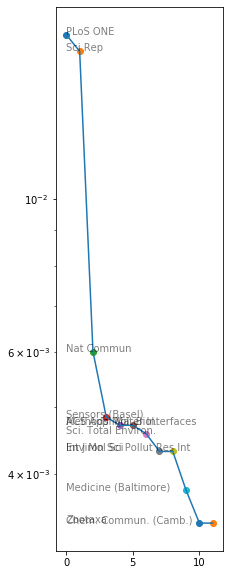

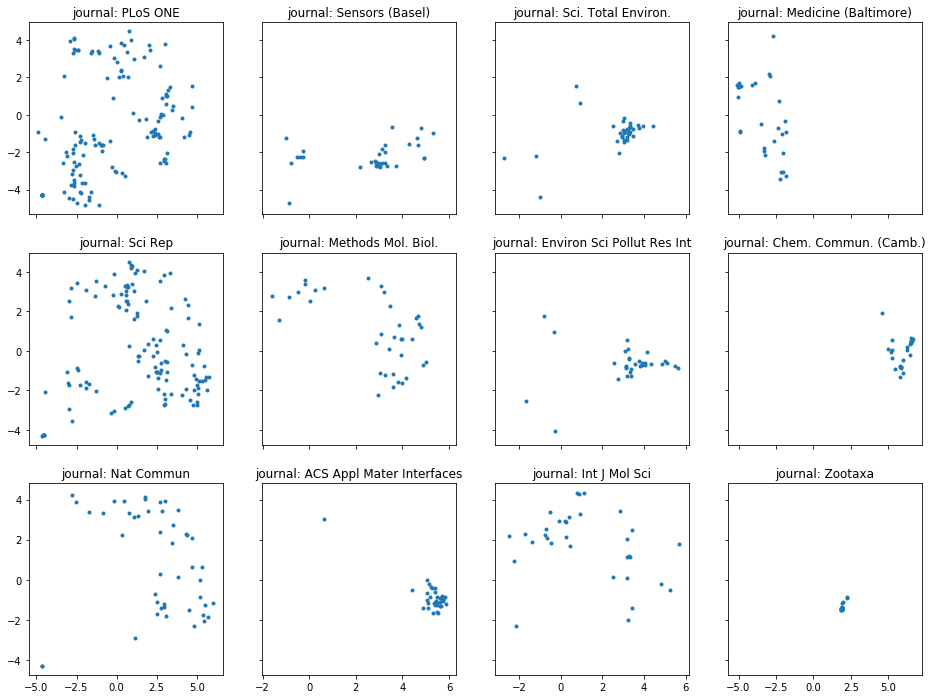

In [20]:
for i_sample in range(N_samplesets):
    
    sample_pmids = samples[i_sample]['pmids']
    
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])

    sql = '''SELECT M.journal, COUNT(*) as count
            FROM metadata as M
            WHERE M.pmid IN ({})
            GROUP BY M.journal
            ORDER BY count DESC'''.format(str_fmt)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    top_journals = []
    journal_counts = []
    for i,row in enumerate(cursor):
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        top_journals.append(row[0])
        journal_counts.append(row[1])
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL results fetched and cast in {} s".format(elapsed))
    
    print('number of unique journals in the sample: ')
    print(len(top_journals)) # sanity check
    print(len(journal_counts))
    sample_size = np.sum(journal_counts)
    journal_counts = journal_counts / sample_size
    
    topK = 12
    plt.figure(figsize=(3,10))
    plt.gca().set_yscale('log')
    plt.plot(journal_counts[:topK])
    for i_journal, journal in enumerate(top_journals[:topK]):
        plt.scatter(i_journal, journal_counts[i_journal],marker='o')
        plt.text(0, journal_counts[i_journal], journal, alpha=0.5)
        
    plt.savefig("figures_2/sample {}: top journals.png".format(i_sample))
    plt.savefig("figures_2/sample {}: top journals.pdf".format(i_sample))
    print(top_journals[:topK])
    
    ######################################################################
    
    sample_pmids = samples[i_sample]['pmids']
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
    
    sql = '''SELECT M.pmid, M.journal
            FROM metadata as M
            WHERE M.pmid IN ({})
            ORDER BY M.journal'''.format(str_fmt)
    
    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
  # print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    results = {}
    for i,row in enumerate(cursor):
        #print(row)
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        try:
            results[row[1]].append(row[0])
        except:
            results[row[1]] = []
            results[row[1]].append(row[0])
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    #print("SQL results fetched and cast in {} s".format(elapsed))
    
    # filter results so they include only the top K journals (don't really need this step)
    filtered_results = {}
    for journal,pmids in results.items():
        if journal in top_journals[:topK]:
            filtered_results[journal] = pmids
            
            
    # plot the journal coordinates for the top K journals
    N_COL, N_ROW = 3, 4
    fig, axs = plt.subplots(N_COL, N_ROW, sharex='col', sharey='row',
                           figsize=(16,12))
    
    for i_journal, journal in enumerate(top_journals[:topK]):
        
        # subplot grid
        i_col = math.floor(i_journal / N_COL)
        i_row = i_journal % N_COL
        
        journal_pmids = filtered_results[journal]
        str_fmt = ', '.join([str(pmid) for pmid in journal_pmids])

        sql = '''SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                WHERE E.pmid IN ({})'''.format(str_fmt)
        
        start_time = time.time()
        cursor = db.cursor()
        cursor.execute(sql)
        end_time = time.time()
        elapsed = end_time - start_time
        #print("SQL join executed in {} s".format(elapsed))

        start_time = time.time()
        pub_embeddings = []
        pub_pmids = []
        for i,row in enumerate(cursor):
            print_block_len = 100000
            if (i+1) % print_block_len == 0:
                print('fetched {} rows...'.format(print_block_len))
            pub_pmids.append(row[0])
            pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
        cursor.close()
        end_time = time.time()
        elapsed = end_time - start_time
        #print("SQL results fetched and cast in {} s".format(elapsed))
        
        #print('compressing...')
        journal_coords = umap_model.transform(pub_embeddings)
        #print('finished compressing')
        
        axs[i_row][i_col].scatter(journal_coords[:,0], journal_coords[:,1], marker='.')
        axs[i_row][i_col].set_title('journal: {}'.format(journal))
    
        plt.savefig('figures_2/top 12 journals in sample.png')
        plt.savefig('figures_2/top 12 journals in sample.pdf')

SQL join executed in 0.14351129531860352 s
SQL results fetched and cast in 0.0032401084899902344 s
number of unique journals in the sample: 
3225
3225
['PLoS ONE', 'Sci Rep', 'Nat Commun', 'Environ Sci Pollut Res Int', 'Sensors (Basel)', 'Sci. Total Environ.', 'Methods Mol. Biol.', 'ACS Appl Mater Interfaces', 'Molecules', 'Int J Mol Sci', 'Medicine (Baltimore)', 'Opt Express', 'Proc. Natl. Acad. Sci. U.S.A.', 'Front Immunol', 'J. Am. Chem. Soc.', 'World Neurosurg', 'Angew. Chem. Int. Ed. Engl.', 'Data Brief', 'Org. Lett.', 'Phys Chem Chem Phys', 'Front Psychol', 'Dalton Trans', 'Nanoscale', 'Phys. Rev. Lett.', 'Front Microbiol']
SQL join executed in 0.15198135375976562 s
SQL results fetched and cast in 0.003144502639770508 s
number of unique journals in the sample: 
3155
3155
['PLoS ONE', 'Sci Rep', 'Nat Commun', 'Sensors (Basel)', 'Methods Mol. Biol.', 'ACS Appl Mater Interfaces', 'Sci. Total Environ.', 'Environ Sci Pollut Res Int', 'Int J Mol Sci', 'Medicine (Baltimore)', 'Chem. Com

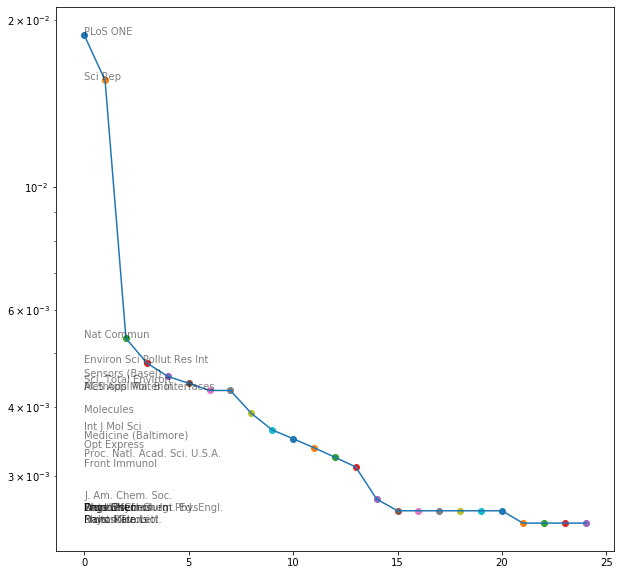

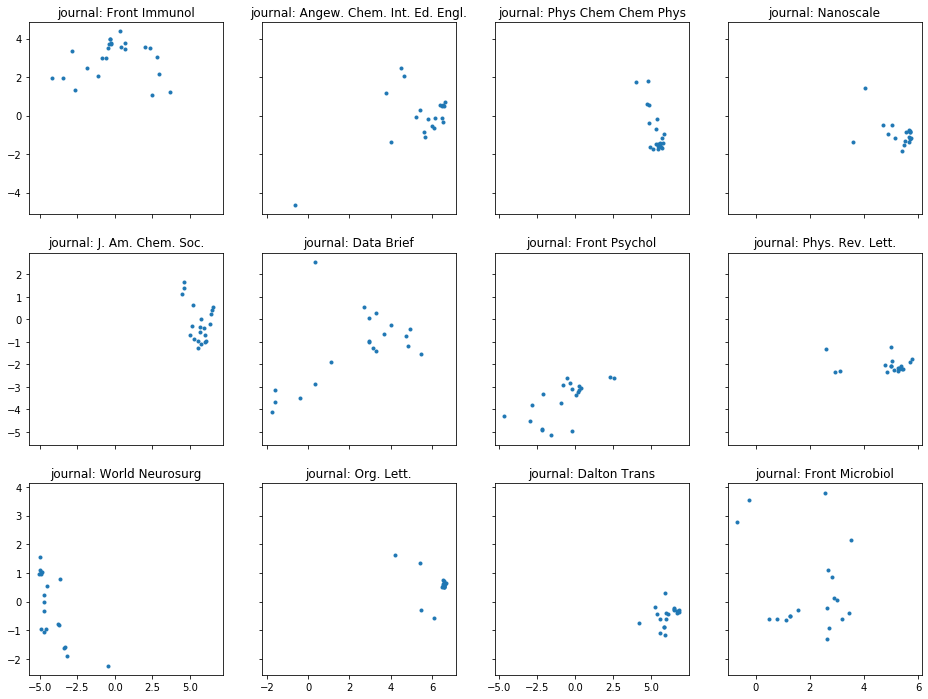

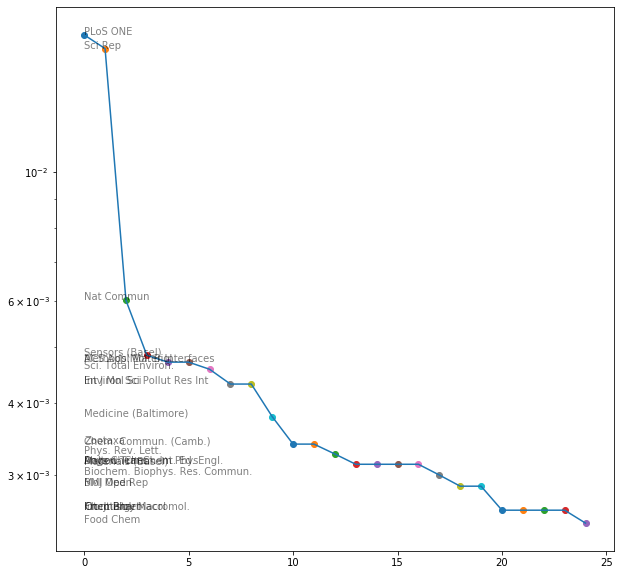

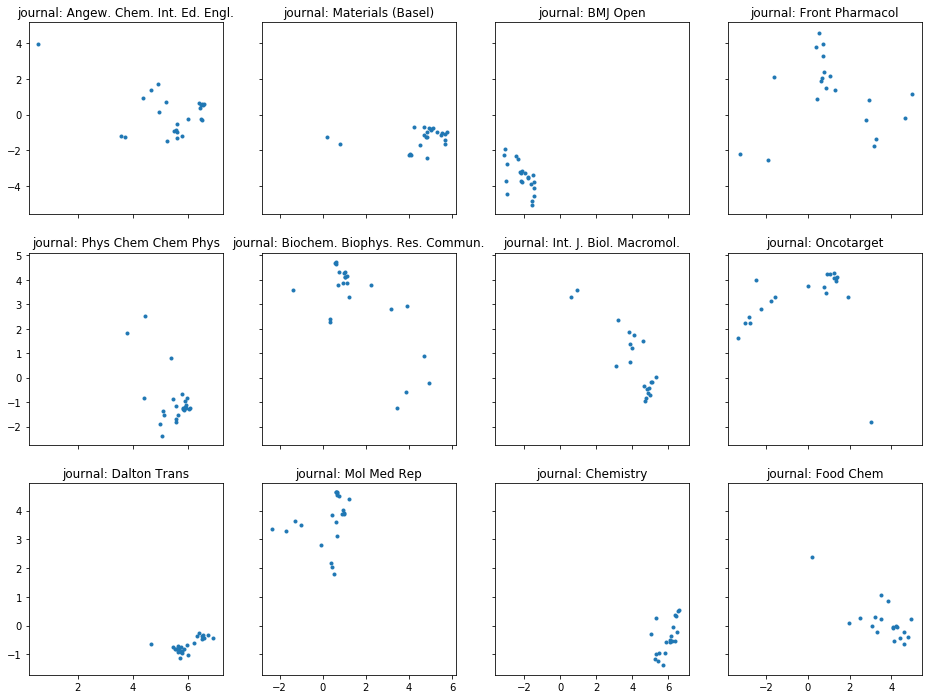

In [19]:
# next 12

for i_sample in range(N_samplesets):
    
    sample_pmids = samples[i_sample]['pmids']
    
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])

    sql = '''SELECT M.journal, COUNT(*) as count
            FROM metadata as M
            WHERE M.pmid IN ({})
            GROUP BY M.journal
            ORDER BY count DESC'''.format(str_fmt)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    top_journals = []
    journal_counts = []
    for i,row in enumerate(cursor):
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        top_journals.append(row[0])
        journal_counts.append(row[1])
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL results fetched and cast in {} s".format(elapsed))
    
    print('number of unique journals in the sample: ')
    print(len(top_journals)) # sanity check
    print(len(journal_counts))
    sample_size = np.sum(journal_counts)
    journal_counts = journal_counts / sample_size
    
    plot_end = 25
    plt.figure(figsize=(10,10))
    plt.gca().set_yscale('log')
    plt.plot(journal_counts[:plot_end])
    for i_journal, journal in enumerate(top_journals[:plot_end]):
        plt.scatter(i_journal, journal_counts[i_journal],marker='o')
        plt.text(0, journal_counts[i_journal], journal, alpha=0.5)
        
    #plt.savefig("sample {}: top journals.png".format(i_sample))
    #plt.savefig("sample {}: top journals.pdf".format(i_sample))
    print(top_journals[:plot_end])
    
    ######################################################################
    
    sample_pmids = samples[i_sample]['pmids']
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
    
    sql = '''SELECT M.pmid, M.journal
            FROM metadata as M
            WHERE M.pmid IN ({})
            ORDER BY M.journal'''.format(str_fmt)
    
    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
  # print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    results = {}
    for i,row in enumerate(cursor):
        #print(row)
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        try:
            results[row[1]].append(row[0])
        except:
            results[row[1]] = []
            results[row[1]].append(row[0])
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    #print("SQL results fetched and cast in {} s".format(elapsed))
    
    filtered_results = results
            
            
    # plot the journal coordinates for the top K journals
    N_COL, N_ROW = 3, 4
    fig, axs = plt.subplots(N_COL, N_ROW, sharex='col', sharey='row',
                           figsize=(16,12))
    
    for i_journal, journal in enumerate(top_journals[13:25]):
        
        # subplot grid
        i_col = math.floor(i_journal / N_COL)
        i_row = i_journal % N_COL
        
        journal_pmids = filtered_results[journal]
        str_fmt = ', '.join([str(pmid) for pmid in journal_pmids])

        sql = '''SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                WHERE E.pmid IN ({})'''.format(str_fmt)
        
        start_time = time.time()
        cursor = db.cursor()
        cursor.execute(sql)
        end_time = time.time()
        elapsed = end_time - start_time
        #print("SQL join executed in {} s".format(elapsed))

        start_time = time.time()
        pub_embeddings = []
        pub_pmids = []
        for i,row in enumerate(cursor):
            print_block_len = 100000
            if (i+1) % print_block_len == 0:
                print('fetched {} rows...'.format(print_block_len))
            pub_pmids.append(row[0])
            pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
        cursor.close()
        end_time = time.time()
        elapsed = end_time - start_time
        #print("SQL results fetched and cast in {} s".format(elapsed))
        
        #print('compressing...')
        journal_coords = umap_model.transform(pub_embeddings)
        #print('finished compressing')
        
        axs[i_row][i_col].scatter(journal_coords[:,0], journal_coords[:,1], marker='.')
        axs[i_row][i_col].set_title('journal: {}'.format(journal))
    

In [ ]:

# check random 12 journals for each sample

for i_sample in range(N_samplesets):
    
    sample_pmids = samples[i_sample]['pmids']
    
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])

    sql = '''SELECT M.journal, COUNT(*) as count
            FROM metadata as M
            WHERE M.pmid IN ({})
            GROUP BY M.journal
            ORDER BY RAND()'''.format(str_fmt)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    top_journals = []
    journal_counts = []
    for i,row in enumerate(cursor):
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        top_journals.append(row[0])
        journal_counts.append(row[1])
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL results fetched and cast in {} s".format(elapsed))
    
    print(len(top_journals)) # sanity check
    print(len(journal_counts))
    sample_size = np.sum(journal_counts)
    journal_counts = journal_counts / sample_size
    
    topK = 12
    plt.figure(figsize=(3,10))
    plt.gca().set_yscale('log')
    plt.plot(journal_counts[:topK])
    for i_journal, journal in enumerate(top_journals[:topK]):
        plt.scatter(i_journal, journal_counts[i_journal],marker='o')
        plt.text(0, journal_counts[i_journal], journal, alpha=0.5)
        
    plt.savefig("sample {}: top journals.png".format(i_sample))
    plt.savefig("sample {}: top journals.pdf".format(i_sample))
    print(top_journals[:topK])
    
    ######################################################################
    
    sample_pmids = samples[i_sample]['pmids']
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
    
    sql = '''SELECT M.pmid, M.journal
            FROM metadata as M
            WHERE M.pmid IN ({})
            ORDER BY M.journal'''.format(str_fmt)
    
    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
  # print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    results = {}
    for i,row in enumerate(cursor):
        #print(row)
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        try:
            results[row[1]].append(row[0])
        except:
            results[row[1]] = []
            results[row[1]].append(row[0])
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    #print("SQL results fetched and cast in {} s".format(elapsed))
    
    # filter results so they include only the top K journals (don't really need this step)
    filtered_results = {}
    for journal,pmids in results.items():
        if journal in top_journals[:topK]:
            filtered_results[journal] = pmids
            
            
    # plot the journal coordinates for the top K journals
    N_COL, N_ROW = 3, 4
    fig, axs = plt.subplots(N_COL, N_ROW, sharex='col', sharey='row',
                           figsize=(16,12))
    
    for i_journal, journal in enumerate(top_journals[:topK]):
        
        # subplot grid
        i_col = math.floor(i_journal / N_COL)
        i_row = i_journal % N_COL
        
        journal_pmids = filtered_results[journal]
        str_fmt = ', '.join([str(pmid) for pmid in journal_pmids])

        sql = '''SELECT E.pmid, E.embedding
                FROM scibert_mean_embedding as E
                WHERE E.pmid IN ({})'''.format(str_fmt)
        
        start_time = time.time()
        cursor = db.cursor()
        cursor.execute(sql)
        end_time = time.time()
        elapsed = end_time - start_time
        #print("SQL join executed in {} s".format(elapsed))

        start_time = time.time()
        pub_embeddings = []
        pub_pmids = []
        for i,row in enumerate(cursor):
            print_block_len = 100000
            if (i+1) % print_block_len == 0:
                print('fetched {} rows...'.format(print_block_len))
            pub_pmids.append(row[0])
            pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
        cursor.close()
        end_time = time.time()
        elapsed = end_time - start_time
        #print("SQL results fetched and cast in {} s".format(elapsed))
        
        #print('compressing...')
        journal_coords = umap_model.transform(pub_embeddings)
        #print('finished compressing')
        
        axs[i_row][i_col].scatter(journal_coords[:,0], journal_coords[:,1], marker='.')
        axs[i_row][i_col].set_title('journal: {}'.format(journal))
    

In [ ]:
# plot the distribution of journals for 10 random journals